In [1]:
import numpy as np, matplotlib.pyplot as plt, torch
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination import get_termination
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.problems.functional import FunctionalProblem

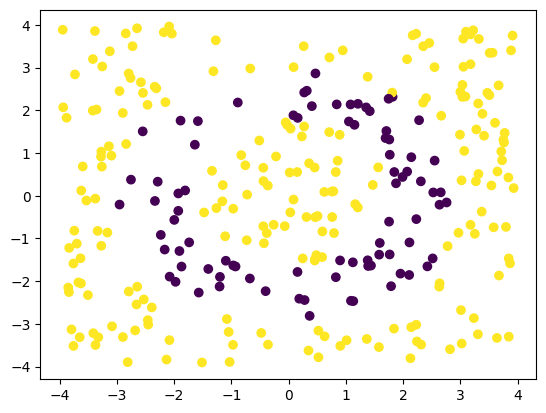

In [2]:
def decison_bound (x,y):
    return x**2 + y**2 <=3 or x**2 + y**2 >=9
def generate_data (n=100, bound=decison_bound):
    X = np.random.uniform(-4,4,(n,2))
    Y = np.array([1 if bound(x[0],x[1]) else 0 for x in X])
    return X,Y

X,Y = generate_data(300)
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

Epoch 0, Loss: 0.7300
Epoch 10, Loss: 0.6859
Epoch 20, Loss: 0.5873
Epoch 30, Loss: 0.4619
Epoch 40, Loss: 0.1041
Epoch 50, Loss: 0.1040
Epoch 60, Loss: 0.0803
Epoch 70, Loss: 0.1154
Epoch 80, Loss: 0.0108
Epoch 90, Loss: 0.0676


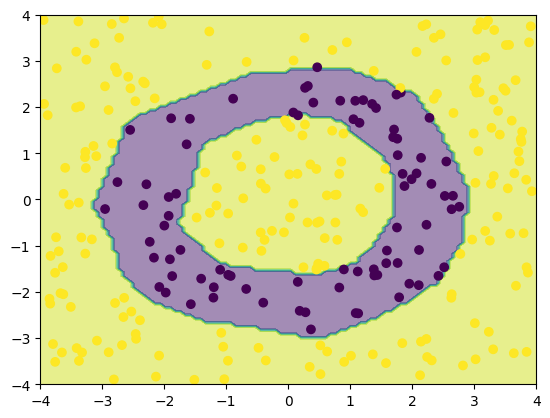

In [3]:
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
dataset = TensorDataset(torch.tensor(X).float(), torch.tensor(Y).long())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
class SimpleNN (nn.Module):
    def __init__ (self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,16),
            nn.ReLU(),
            nn.Linear(16,2)

        )
    def forward (self,x):
        return self.net(x)
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(100):
    for xb, yb in dataloader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
# Visualize decision boundary
xx, yy = np.meshgrid(np.linspace(-4,4,100), np.linspace(-4,4,100))
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()
with torch.no_grad():
    Z = model(grid).argmax(dim=1).numpy().reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

In [46]:

def make_cf_problem(model, x_star, Y_prime, X_obs, weights):

    model.eval()

    # ------- 准备 numpy 版本的数据（pymoo 用 numpy） -------
    x_star_t = x_star.detach().cpu()
    X_obs_t = X_obs.detach().cpu()
    Y_prime_t = Y_prime.detach().cpu()
    w_t = weights.detach().cpu()

    x_star_np = x_star_t.numpy()            # shape: (p,)
    X_obs_np = X_obs_t.numpy()              # shape: (k, p)
    w_np = w_t.numpy()                      # shape: (k,)
    p = x_star_np.shape[0]                  # 特征维数 p

    # 搜索空间：简单用观测数据的 min/max，当作上下界
    xl = X_obs_np.min(axis=0)
    xu = X_obs_np.max(axis=0)

    feature_range = X_obs_np.max(axis=0) - X_obs_np.min(axis=0)
    feature_range[feature_range == 0] = 1.0    # 避免除以 0

    def delta_G_vec(x, y):
        # normalized |x - y| in [0, 1]
        return np.minimum(np.abs(x - y) / feature_range, 1.0)

    # ------- 4 个目标函数（elementwise，输入 1 个 x） -------

    # 1) Validity：o1(f(x), Y') = 0 if f(x) in Y', else inf_{y' in Y'} |f(x) - y'|
    # 这里把 f(x) 当作预测类别（argmax），Y' 当作目标类别集合，
    # 并在类别空间上用 0/1 距离。
    def o1_validity(x):
        x_t = torch.from_numpy(x.astype(np.float32)).unsqueeze(0)  # shape: (1, p)
        with torch.no_grad():
            logits = model(x_t)            # shape: (1, num_classes)
            y_hat_class = int(logits.argmax(dim=1).item())  # 标量类别

        # Y_prime_t 可能是一个标量或 1D 张量，把它统一成类别列表
        target_labels = Y_prime_t.view(-1).long().tolist()

        # formal definition:
        # if f(x) ∈ Y' -> 0
        # else inf_{y'∈Y'} |f(x) - y'|, 用 0/1 距离 => 1
        if y_hat_class in target_labels:
            return 0.0
        else:
            return 1.0

    # 2) Similarity：和 x* 的平均归一化差异（越小越相似）
    def o2_similarity(x):
        return float(delta_G_vec(x, x_star_np).mean())
    EPS = 1e-6    # or something like 1e-8

    def o3_sparsity(x):
        # ||x - x*||_0 = number of coordinates that changed
        diff = np.abs(x - x_star_np) > EPS
        return float(diff.sum())

    def o4_plausibility(x):
        diffs = (X_obs_np - x) / feature_range            # (k, p)
        per_sample = np.sqrt((diffs ** 2).mean(axis=1))   # RMS distance per sample
        w_np_norm = w_np / w_np.sum()
        return float((per_sample * w_np_norm).sum())

    objs = [o1_validity, o2_similarity, o3_sparsity, o4_plausibility]
    problem = FunctionalProblem(
    n_var=p,
    objs=objs,
    xl=xl,
    xu=xu,
    elementwise=True  # 每次传入一个个体 x
)

    return problem

In [61]:
for x, y in dataloader:
    x_star = torch.tensor([-3.0, -3.0])        # original feature vector, tensor shape (p,)
    y_star = model(x_star.unsqueeze(0)).argmax(dim=1)          # original label, tensor scalar
    Y_prime = 1 - y_star   # target label = opposite class, still a tensor
    break

X_obs = dataset.tensors[0]                       # (k, p)
weights = torch.ones(len(X_obs)) / len(X_obs)    # normalized weights

# model:      PyTorch 模型
# x_star:     shape (p,)
# Y_prime:    shape (n_y,)  例如 tensor([1]) 或几种目标输出
# X_obs:      shape (k, p)
# weights:    shape (k,)   且 weights.sum() == 1

problem = make_cf_problem(model, x_star, Y_prime, X_obs, weights)
print(f'problem: \n{problem}\nx_star: {x_star} dtype={x_star.dtype}\ny_star: {y_star} dtype={y_star.dtype}\nY_prime: {Y_prime} dtype={Y_prime.dtype}\n')


problem: 
# name: FunctionalProblem
# n_var: 2
# n_obj: 4
# n_ieq_constr: 0
# n_eq_constr: 0

x_star: tensor([-3., -3.]) dtype=torch.float32
y_star: tensor([1]) dtype=torch.int64
Y_prime: tensor([0]) dtype=torch.int64



In [62]:

# 3. 选择算法（NSGA-II）
algorithm = NSGA2(pop_size=200)

# 4. 终止条件
termination = get_termination("n_gen", 150)

# 5. 运行优化
res = minimize(
    problem,
    algorithm,
    termination,
    seed=1,
    verbose=True
)

F_mmo = res.F   # shape (n_points, 4)  — 4 个目标的值
X_mmo = res.X   # 对应的 x（counterfactual 候选）

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      200 |     24 |             - |             -
     2 |      400 |     38 |  0.0161086118 |             f
     3 |      600 |     56 |  0.0283300066 |         ideal
     4 |      800 |     84 |  0.2918553079 |         nadir
     5 |     1000 |    112 |  0.0161482289 |         ideal
     6 |     1200 |    155 |  0.0029280554 |             f
     7 |     1400 |    192 |  0.0016162887 |             f
     8 |     1600 |    200 |  0.0031595497 |             f
     9 |     1800 |    200 |  0.0236131650 |         nadir
    10 |     2000 |    200 |  0.0025127633 |         ideal
    11 |     2200 |    200 |  0.0008021693 |             f
    12 |     2400 |    200 |  0.0016311007 |             f
    13 |     2600 |    200 |  0.0020713096 |             f
    14 |     2800 |    200 |  0.0028266040 |             f
    15 |     3000 |    200 |  0.0007672678 |             f
    16 |     3200 |    200 |  0.0012367182 |            

In [109]:
valided_F_mmo=np.array([f for f in F_mmo if f[0]==0])
valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]==0])
not_valided_F_mmo=np.array([f for f in F_mmo if f[0]!=0])
not_valided_X_mmo=np.array([X_mmo[i] for i in range(len(F_mmo)) if F_mmo[i][0]!=0])
not_patero_front_X=np.array([X_obs[i] for i in range(len(X_obs)) if i not in res.opt.get("idx")])  # observed instances not in pareto front

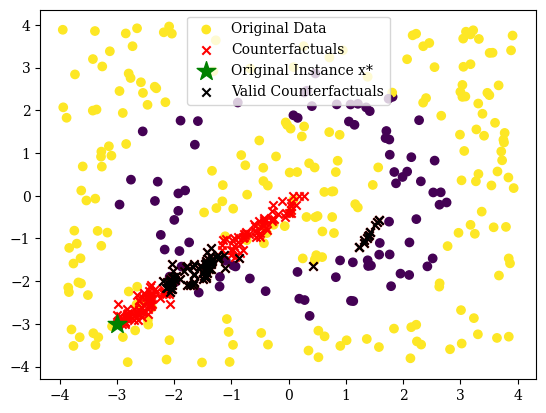

In [110]:

# visualize the conterfactuals candidates in original data space
plt.figure()
plt.scatter(X[:,0],X[:,1],c=Y, label='Original Data')
plt.scatter(X_mmo[:,0], X_mmo[:,1], marker='x', c='red', label='Counterfactuals')
plt.scatter(x_star[0], x_star[1], marker='*', c='green', s=200, label='Original Instance x*')
# color black for valid counterfactuals
plt.scatter(valided_X_mmo[:,0], valided_X_mmo[:,1], marker='x', c='black', label='Valid Counterfactuals')
plt.legend()

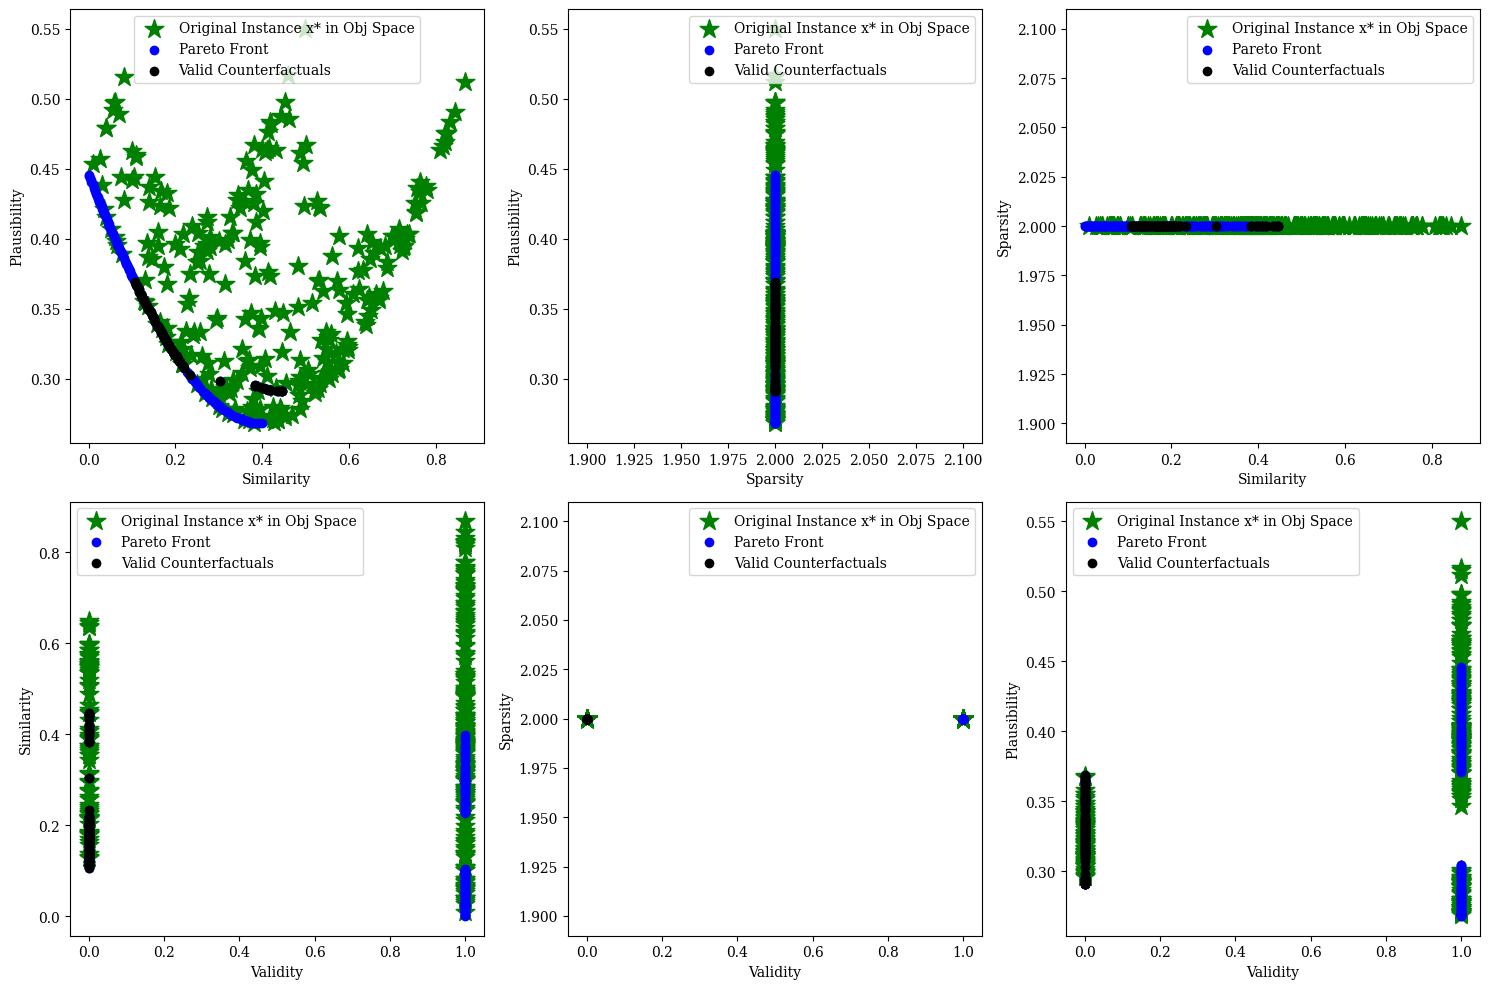

In [111]:
# visualize the Pareto front in objective space
fig, ax = plt.subplots(2, 3, figsize=(15, 10))

# Create pairs of objective indices to plot
obj_pairs = [(1, 3), (2, 3), (1, 2), (0, 1), (0, 2), (0, 3)]
obj_labels = ['Validity', 'Similarity', 'Sparsity', 'Plausibility']

for i, (obj_x, obj_y) in enumerate(obj_pairs):
    row = i // 3
    col = i % 3
    ax[row, col].scatter(problem.evaluate(X)[:, obj_x],
                         problem.evaluate(X)[:, obj_y],
                         marker='*', c='green', s=200, label='Original Instance x* in Obj Space')
    ax[row, col].scatter(F_mmo[:, obj_x], F_mmo[:, obj_y], c='blue', label='Pareto Front')
    ax[row, col].scatter(valided_F_mmo[:, obj_x], valided_F_mmo[:, obj_y], c='black', label='Valid Counterfactuals')
    ax[row, col].set_xlabel(obj_labels[obj_x])
    ax[row, col].set_ylabel(obj_labels[obj_y])
    ax[row, col].legend()

plt.tight_layout()
plt.show()

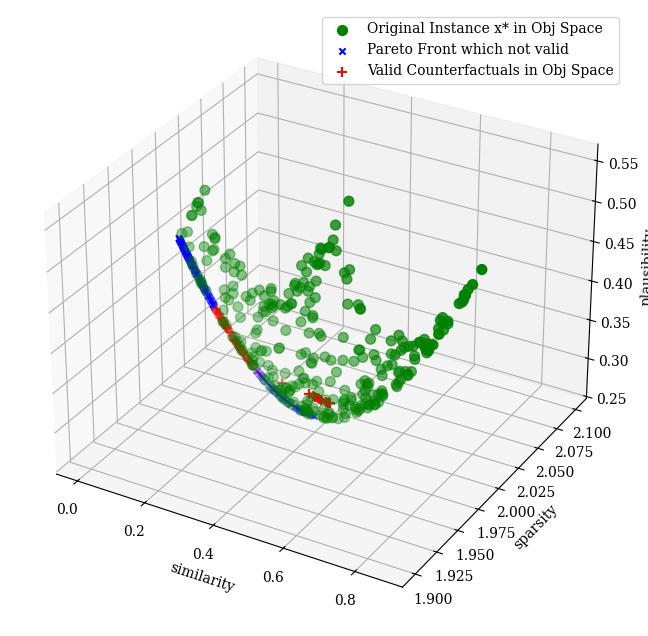

In [114]:


# visualize the Pareto front in 3D objective space
plt.figure(figsize=(10, 8))
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')

ax.scatter(problem.evaluate(X)[:,1],
            problem.evaluate(X)[:,2],
            problem.evaluate(X)[:,3],
            marker='.', c='green', s=200, label='Original Instance x* in Obj Space')
ax.scatter(not_valided_F_mmo[:,1], not_valided_F_mmo[:,2], not_valided_F_mmo[:,3], c='blue', label='Pareto Front which not valid', marker='x', s=20)
# color black for valid counterfactuals
ax.scatter(valided_F_mmo[:,1], valided_F_mmo[:,2], valided_F_mmo[:,3], c='red', label='Valid Counterfactuals in Obj Space', marker='+', s=50)
ax.set_xlabel('similarity')
ax.set_ylabel('sparsity')
ax.set_zlabel('plausibility')

plt.legend()
plt.show()

In [12]:
poi=np.array([[0,0]])
problem.evaluate(poi), model(torch.tensor(poi).float().unsqueeze(0)).argmax(dim=1), Y_prime

(array([[0.        , 0.20342529, 2.        , 0.26868186]]),
 tensor([[0, 0]]),
 tensor(1))

In [ ]:
poi=np.array([[0,-1]])
model(torch.from_numpy(poi.astype(np.float32)))

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [ ]:
torch.from_numpy(poi.astype(np.float32)).unsqueeze(0).shape, 

torch.Size([1, 2])

In [73]:
X_mmo

array([[-3.42193617,  1.53658446],
       [-2.40951531,  1.53658457],
       [-2.58298263,  1.37589384]])